In [108]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
import jax.numpy as jnp
from transformer_payne import Blackbody, TransformerPayne
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [109]:
measurements = Table.read('v1726_cygni.fits', hdu=1, format='fits')
period = measurements['PERIOD'][0]
print('Period:', period, 'days')

Period: 4.236736 days


In [110]:
spips_data = Table.read('v1726_cygni.fits', hdu=2, format='fits')

In [111]:
start_temp = spips_data['Teff'][0]
start_R = spips_data['R'][0]
start_logg = spips_data['logg'][0]

print('Start temperature:', start_temp, 'K')
print('Start radius:', start_R, 'Rsol')
print('Start logg:', start_logg, 'dex')

Start temperature: 6155.6504 K
Start radius: 55.569435 Rsol
Start logg: 1.9870918 dex


<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/jobfs/141002550.gadi-pbs/ipykernel_159320/1824795726.py:7: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_ylabel('R (R$_\odot$)')


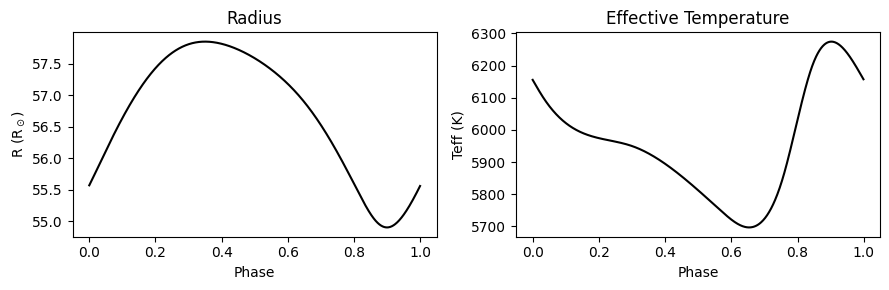

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

# Plot radius
axs[0].plot(spips_data['PHASE'], spips_data['R'], color='black')
axs[0].set_title('Radius')
axs[0].set_xlabel('Phase')
axs[0].set_ylabel('R (R$_\odot$)')

# Plot temperature
axs[1].plot(spips_data['PHASE'], spips_data['Teff'], color='black')
axs[1].set_title('Effective Temperature')
axs[1].set_xlabel('Phase')
axs[1].set_ylabel('Teff (K)')

plt.tight_layout()

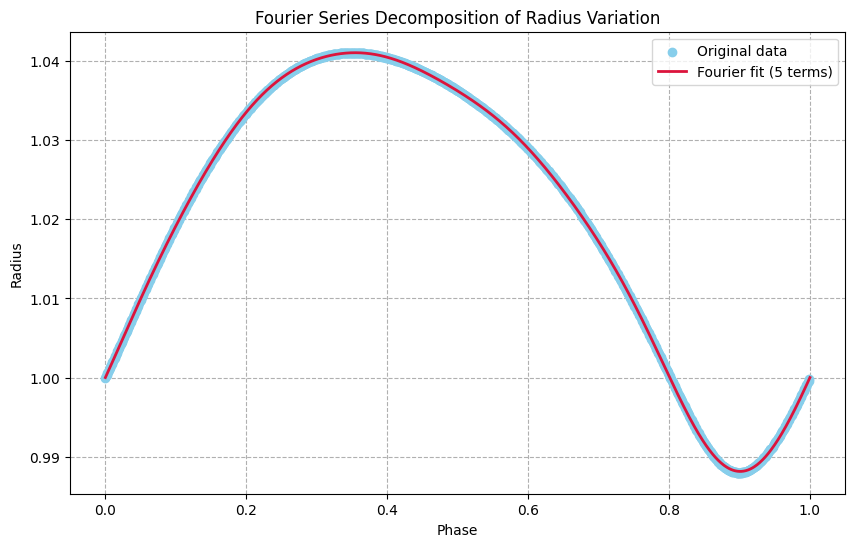

In [113]:
from spice.utils.fourier_fit import fit_fourier_series
from spice.models.mesh_transform import add_pulsation

# Your Cepheid data
radius = spips_data['R']/spips_data['R'][0]
phases = spips_data['PHASE']

# Fit the Fourier series (use appropriate spherical harmonic mode)
result = fit_fourier_series(
    radius=radius,
    phases=phases,
    period=period,
    n_terms=5,
    m_order=0,
    n_degree=0,
    plot=True
)

# Model

In [114]:
b = Blackbody()
tp = TransformerPayne.download()

In [115]:
mb = IcosphereModel.construct(
    n_vertices=1000,
    radius=start_R,
    mass=6.,
    parameters=b.to_parameters(dict(Teff=start_temp)),
    parameter_names=b.parameter_names
)

mb_tp = IcosphereModel.construct(
    n_vertices=1000,
    radius=start_R,
    mass=6.,
    parameters=tp.to_parameters(dict(logteff=np.log10(start_temp), logg=start_logg)),
    parameter_names=tp.stellar_parameter_names
)
timestamps = jnp.linspace(0, 4.236736, 100)

mb_p = add_pulsation(mb, 0, 0, 4.236736, result)
mb_p_e = [evaluate_pulsations(mb_p, t) for t in timestamps]

mb_p_tp = add_pulsation(mb_tp, 0, 0, 4.236736, result)
mb_p_tp_e = [evaluate_pulsations(mb_p_tp, t) for t in timestamps]

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/transformer_payne/transformer_payne.py:579: UserWarning: Possible exceeding parameter bonds - extrapolating.
  warnings.warn("Possible exceeding parameter bonds - extrapolating.")


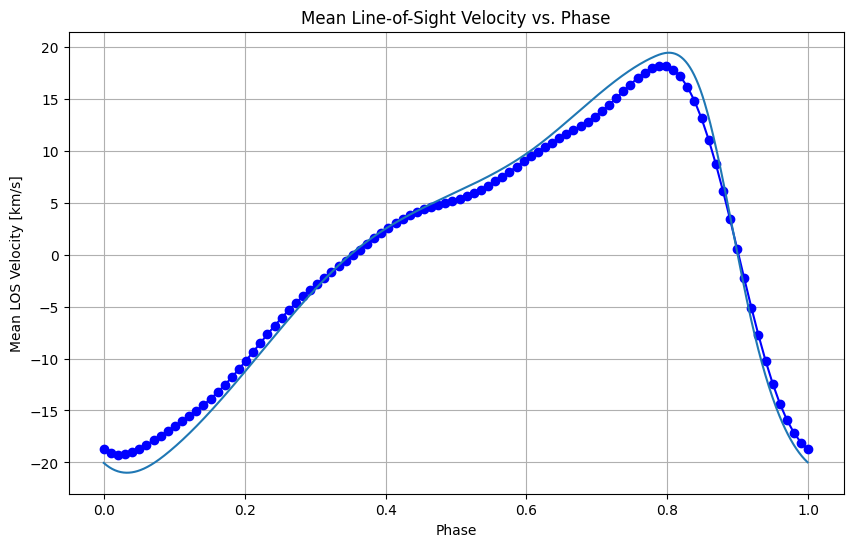

In [116]:
# Create a figure to plot the mean line-of-sight velocities over time
plt.figure(figsize=(10, 6))

# Calculate the mean line-of-sight velocities for each time step
mean_los_velocities = [-2*jnp.pi*np.mean(model.los_velocities[model.mus>0]) for model in mb_p_tp_e]


# Convert time to phase for plotting
phases = (timestamps / period) % 1.0

# Plot the mean line-of-sight velocities
plt.plot(phases, mean_los_velocities, 'o-', color='blue')
plt.plot(spips_data['PHASE'], spips_data['Vpuls'])
plt.xlabel('Phase')
plt.ylabel('Mean LOS Velocity [km/s]')
plt.title('Mean Line-of-Sight Velocity vs. Phase')
plt.grid(True)
plt.show()

In [50]:
# Interpolate mean_los_velocities to match the shape of pulsation_data
from scipy.interpolate import interp1d

# Create interpolation function based on phases
los_velocity_interp = interp1d(phases, mean_los_velocities, kind='cubic', fill_value='extrapolate')

# Interpolate to match pulsation_data phases
interpolated_los_velocities = los_velocity_interp(spips_data['PHASE'])

# Now we can compare them
spips_data['Vpuls']/interpolated_los_velocities

-6.71889193766686
-6.721800136511245
-6.724921302423411
-6.72824827591513
-6.731772199086831
-6.735485699985532
-6.73938093373551
-6.7434502432359675
-6.747686118742207
-6.7520818264330265
-6.756630100621659


In [11]:
from spice.utils.parameters import modify_mesh_parameter_from_array
# Create interpolation functions for Teff and logg based on phase
from scipy.interpolate import interp1d

# Extract phase, Teff, and logg data from pulsation_data
phase_data = spips_data['PHASE'].data
teff_data = spips_data['Teff'].data
logg_data = spips_data['logg'].data

# Ensure phase data is sorted for interpolation
sort_idx = np.argsort(phase_data)
sorted_phase = phase_data[sort_idx]
sorted_teff = teff_data[sort_idx]
sorted_logg = logg_data[sort_idx]

# Create interpolation functions
# Use 'cubic' for smooth interpolation and 'period=1' since phase wraps around
teff_interp = interp1d(sorted_phase, sorted_teff, kind='cubic', bounds_error=False, 
                      fill_value=(sorted_teff[-1], sorted_teff[0]), assume_sorted=True)
                      
logg_interp = interp1d(sorted_phase, sorted_logg, kind='cubic', bounds_error=False,
                      fill_value=(sorted_logg[-1], sorted_logg[0]), assume_sorted=True)

# Function to get Teff and logg at any phase
def get_teff_at_phase(phase):
    phase = phase % 1.0
    return teff_interp(phase)

def get_logg_at_phase(phase):
    phase = phase % 1.0
    return logg_interp(phase)
    

# Calculate phase from timestamps and period
phases = [(t % period) / period for t in timestamps]

mb_ps = [modify_mesh_parameter_from_array(_mp, 0, get_teff_at_phase(phase)) for _mp, phase in zip(mb_p_e, phases)]

m_tp_ps = [modify_mesh_parameter_from_array(_mp, 0, jnp.log10(get_teff_at_phase(phase))) for _mp, phase in zip(mb_p_tp_e, phases)]
m_tp_ps = [modify_mesh_parameter_from_array(_mp, 1, get_logg_at_phase(phase)) for _mp, phase in zip(m_tp_ps, phases)]

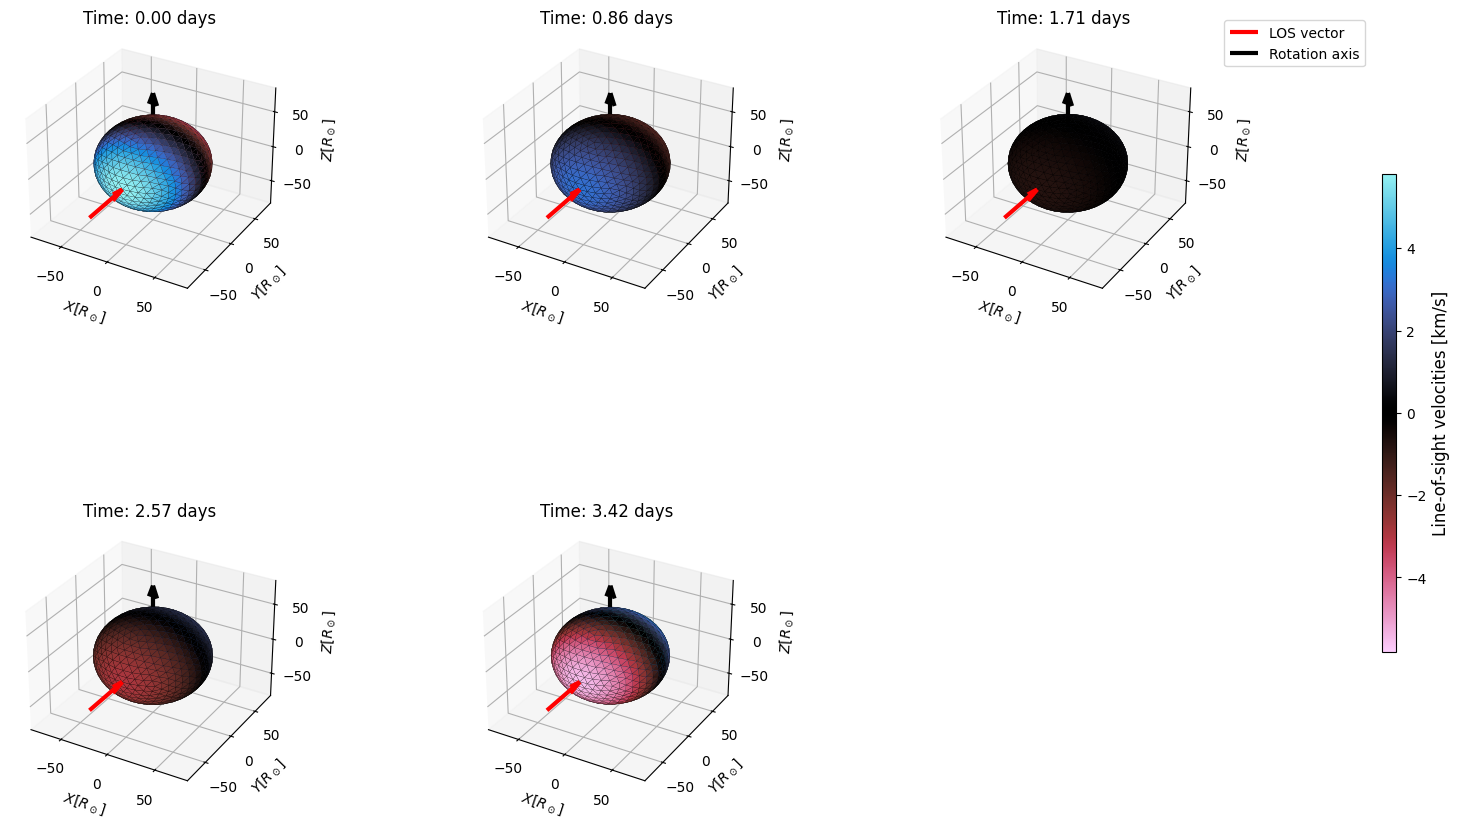

In [12]:
from spice.plots.plot_mesh import plot_3D_sequence
plot_3D_sequence(mb_ps[::20], timestamps=timestamps[::20], timestamp_label='days',
                 property='los_velocities', property_label='Line-of-sight velocities [km/s]', figsize=(15, 10));

In [13]:
from spice.spectrum import simulate_observed_flux

vws = jnp.linspace(3000, 10000, 10000)

spectra_bb = [simulate_observed_flux(b.intensity, _mp, jnp.log10(vws), distance=2.658) for _mp in tqdm(mb_ps, desc='Simulating spectra')]
spectra_tp = [simulate_observed_flux(tp.intensity, _mp, jnp.log10(vws), distance=2.658) for _mp in tqdm(m_tp_ps, desc='Simulating spectra with Transformer Payne')]

Simulating spectra with Transformer Payne:   0%|                                                                                             | 0/100 [00:00<?, ?it/s]/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/linear_util.py:370: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in logspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ans = _fun(*args, **kwargs)
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://g

In [14]:
from spice.plots.plot_mesh import plot_3D_mesh_and_spectrum

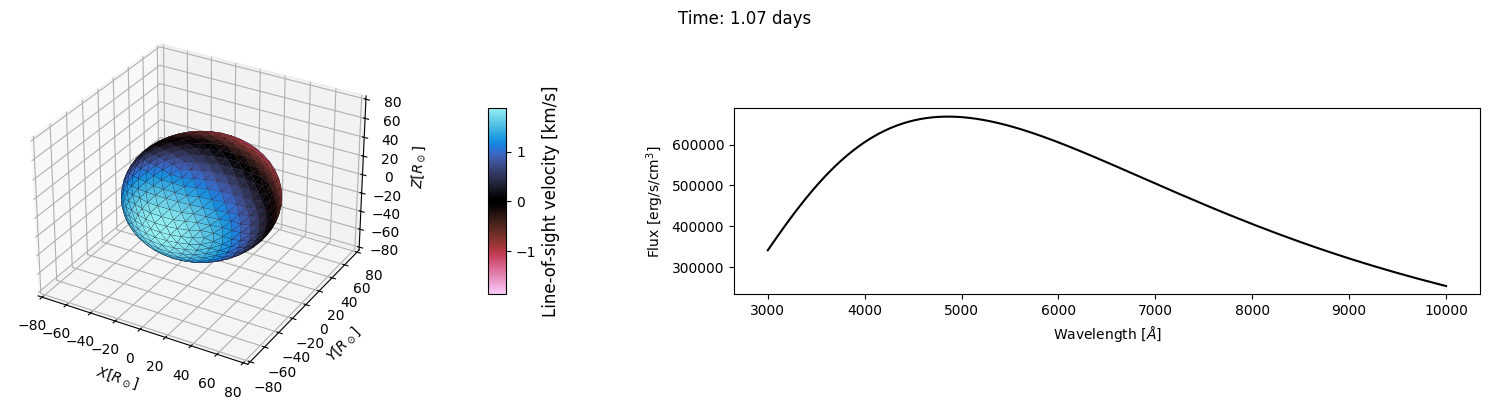

In [13]:
i = 25
plot_3D_mesh_and_spectrum(mb_ps[i], np.array(spectra_bb)[i, :, 0], vws, draw_los_vector=False, draw_rotation_axis=False,
                       timestamp=timestamps[i], timestamp_label='days', property='los_velocities', property_label='Line-of-sight velocity [km/s]');

In [15]:
from spice.plots.plot_mesh import animate_mesh_and_spectra
animate_mesh_and_spectra(mb_ps, np.array(spectra_bb)[:, :, 0], vws,
                         filename='v_cygni_spectra_bb.gif',
                         property=0, property_label='Effective temperature [K]', timestamps=timestamps, timestamp_label='days');

In [16]:
#from spice.plots.plot_mesh import animate_mesh_and_spectra
animate_mesh_and_spectra(m_tp_ps, np.array(spectra_tp)[:, :, 0], vws,
                         filename='v_cygni_spectra_tp.gif',
                         property=0, property_label=r'log($T_{eff}$) [log(K)]');

In [20]:

from matplotlib.animation import FuncAnimation
from spice.plots.plot_mesh import smart_save
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
import numpy as np
import cmasher as cmr


def animate_mesh_and_spectra_custom_prop(meshes, spectra, wavelengths, 
                             property=None, 
                             cmap=None, 
                             property_label=None,
                             filename='mesh_and_spectra_animation.mp4',
                             figsize=(15, 5),
                             mode='MESH',
                             draw_los_vector=True,
                             draw_rotation_axis=True,
                             linewidth=0.1,
                             axes_lim=None,
                             timestamps=None,
                             timestamp_label=None):
    # Setup timestamp label
    timestamp_label = timestamp_label or ''
    
    # Get property data for coloring the mesh
    to_be_mapped_arrays = property
    
    cbar_label = property_label
    to_be_mapped_arrays_concatenated = np.concatenate(to_be_mapped_arrays)
    
    # Set up the colormap
    if cmap is None:
        cmap = cmr.bubblegum
        
    # Determine axis limits
    if axes_lim is None:
        axes_lim = 1.5 * max([mesh.radius for mesh in meshes])
    
    # Create figure with two subplots: 3D mesh and spectrum
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(4, 4, width_ratios=[1, 0.05, 0.05, 2])

    # 3D mesh subplot
    mesh_ax = fig.add_subplot(gs[:, 0], projection='3d')
    mesh_ax.set_xlim3d(-axes_lim, axes_lim)
    mesh_ax.set_ylim3d(-axes_lim, axes_lim)
    mesh_ax.set_zlim3d(-axes_lim, axes_lim)
    mesh_ax.set_xlabel('$X [R_\\odot]$', fontsize=10)
    mesh_ax.set_ylabel('$Y [R_\\odot]$', fontsize=10)
    mesh_ax.set_zlabel('$Z [R_\\odot]$', fontsize=10)
    
    # Spectrum subplot
    spec_ax = fig.add_subplot(gs[1:3, 3])
    spec_ax.set_xlabel('Wavelength [$\AA$]', fontsize=10)
    spec_ax.set_ylabel('Flux [erg/s/cm$^3$]', fontsize=10)
    
    # Set up color normalization for the mesh
    norm = mpl.colors.Normalize(vmin=to_be_mapped_arrays_concatenated.min(), 
                               vmax=to_be_mapped_arrays_concatenated.max())
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    # Add colorbar for the mesh
    cbar_ax = fig.add_subplot(gs[1:3, 1])
    cbar = plt.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=12)
    
    # Find min/max for spectrum y-axis
    spec_min = np.min(spectra)
    spec_max = np.max(spectra)
    spec_padding = 0.05 * (spec_max - spec_min)
    spec_ax.set_ylim(spec_min - spec_padding, spec_max + spec_padding)
    
    # Initial spectrum line
    spectrum_line, = spec_ax.plot(wavelengths, spectra[0], color='black')
    plt.tight_layout()
    
    # Animation update function
    def update(frame):
        mesh_ax.clear()
        
        # Reset axis properties
        mesh_ax.set_xlim3d(-axes_lim, axes_lim)
        mesh_ax.set_ylim3d(-axes_lim, axes_lim)
        mesh_ax.set_zlim3d(-axes_lim, axes_lim)
        mesh_ax.set_xlabel('$X [R_\\odot]$', fontsize=10)
        mesh_ax.set_ylabel('$Y [R_\\odot]$', fontsize=10)
        mesh_ax.set_zlabel('$Z [R_\\odot]$', fontsize=10)
        
        # Get current mesh and property data
        mesh = meshes[frame]
        to_be_mapped = to_be_mapped_arrays[frame]
        
        # Draw los vector and rotation axis
        if draw_los_vector:
            normalized_los_vector = mesh.los_vector/np.linalg.norm(mesh.los_vector)
            mesh_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                        color='red', linewidth=3., label='LOS vector')
        
        if draw_rotation_axis:
            normalized_rotation_axis = mesh.rotation_axis/np.linalg.norm(mesh.rotation_axis)
            mesh_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                        color='black', linewidth=3., label='Rotation axis')
        
        # Visualize mesh according to mode
        if mode == 'MESH':
            vs2 = mesh.vertices[mesh.faces.astype(int)]
            face_colors =cmr.bubblegum(norm(to_be_mapped))
            mesh_collection = art3d.Poly3DCollection(vs2, facecolors=face_colors, 
                                                   edgecolor="black", linewidths=linewidth)
            mesh_ax.add_collection(mesh_collection)
        else:  # mode == 'POINTS'
            mesh_collection = mesh_ax.scatter(mesh.centers[:, 0], mesh.centers[:, 1], mesh.centers[:, 2],
                                           c=to_be_mapped, cmap=cmap, norm=norm)
        
        # Update spectrum
        spectrum_line.set_ydata(spectra[frame])
        
        # Add timestamp if available
        if timestamps is not None:
            title = f"Time: {timestamps[frame]:.2f} {timestamp_label}"
            fig.suptitle(title, y=0.85)
        
        # Only show legend in the first frame or if explicitly asked
        if frame == 0 and (draw_los_vector or draw_rotation_axis):
            mesh_ax.legend(loc='upper right', fontsize=10)
        
        return [mesh_collection, spectrum_line]
    
    # Create and save animation
    anim = FuncAnimation(fig, update, frames=len(meshes), blit=False)
    smart_save(anim, filename, fps=20)
    
    plt.close(fig)
    return filename

<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:56: SyntaxWarning: invalid escape sequence '\A'
/jobfs/140539963.gadi-pbs/ipykernel_14509/3882313275.py:56: SyntaxWarning: invalid escape sequence '\A'
  spec_ax.set_xlabel('Wavelength [$\AA$]', fontsize=10)


In [21]:
animate_mesh_and_spectra_custom_prop(m_tp_ps, np.array(spectra_tp)[:, :, 0], vws,
                                     property=10**jnp.array([_m.parameters[:, 0] for _m in m_tp_ps]), property_label=r'$T_{eff}$ [K]',
                                     filename='v_cygni_spectra_tp.gif')

'v_cygni_spectra_tp.gif'

In [22]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonCousinsV, JohnsonCousinsR, JohnsonCousinsB, GaiaG, Bolometric

from tqdm import tqdm

johnson_cousins_v = JohnsonCousinsV()
johnson_cousins_r = JohnsonCousinsR()
gaia_g = GaiaG()
johnson_cousins_b = JohnsonCousinsB()
bolometric = Bolometric()

# Blackbody model
filters_bb = [
    ('V', johnson_cousins_v),
    ('R', johnson_cousins_r),
    ('G', gaia_g),
    ('B', johnson_cousins_b),
    ('Bol', bolometric),
    ('Gaia', gaia_g)
]

v_lum_bb, r_lum_bb, g_lum_bb, b_lum_bb, bol_lum_bb, gaia_lum_bb = [], [], [], [], [], []
for s in tqdm(spectra_bb, desc='Computing BB filter luminosities'):
    v_lum_bb.append(AB_passband_luminosity(johnson_cousins_v, vws, s[:, 0]))
    r_lum_bb.append(AB_passband_luminosity(johnson_cousins_r, vws, s[:, 0]))
    g_lum_bb.append(AB_passband_luminosity(gaia_g, vws, s[:, 0]))
    b_lum_bb.append(AB_passband_luminosity(johnson_cousins_b, vws, s[:, 0]))
    bol_lum_bb.append(AB_passband_luminosity(bolometric, vws, s[:, 0]))
    gaia_lum_bb.append(AB_passband_luminosity(gaia_g, vws, s[:, 0]))

# Transformer Payne model
v_lum_tp, r_lum_tp, g_lum_tp, b_lum_tp, bol_lum_tp, gaia_lum_tp = [], [], [], [], [], []
for s in tqdm(spectra_tp, desc='Computing Transformer Payne filter luminosities'):
    v_lum_tp.append(AB_passband_luminosity(johnson_cousins_v, vws, s[:, 0]))
    r_lum_tp.append(AB_passband_luminosity(johnson_cousins_r, vws, s[:, 0]))
    g_lum_tp.append(AB_passband_luminosity(gaia_g, vws, s[:, 0]))
    b_lum_tp.append(AB_passband_luminosity(johnson_cousins_b, vws, s[:, 0]))
    bol_lum_tp.append(AB_passband_luminosity(bolometric, vws, s[:, 0]))
    gaia_lum_tp.append(AB_passband_luminosity(gaia_g, vws, s[:, 0]))

Computing Transformer Payne filter luminosities: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.67it/s]


In [42]:

from matplotlib.animation import FuncAnimation
from spice.plots.plot_mesh import smart_save
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
import numpy as np
import cmasher as cmr


def animate_mesh_and_lightcurve_custom_prop(meshes, lc, timestamsps, 
                             property=None, 
                             cmap=None, 
                             property_label=None,
                             filename='mesh_and_spectra_animation.mp4',
                             figsize=(15, 5),
                             mode='MESH',
                             draw_los_vector=True,
                             draw_rotation_axis=True,
                             linewidth=0.1,
                             axes_lim=None):
    
    # Get property data for coloring the mesh
    to_be_mapped_arrays = property
    
    cbar_label = property_label
    to_be_mapped_arrays_concatenated = np.concatenate(to_be_mapped_arrays)
    
    # Set up the colormap
    if cmap is None:
        cmap = cmr.bubblegum
        
    # Determine axis limits
    if axes_lim is None:
        axes_lim = 1.5 * max([mesh.radius for mesh in meshes])
    
    # Create figure with two subplots: 3D mesh and spectrum
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(4, 4, width_ratios=[1, 0.05, 0.05, 2])

    # 3D mesh subplot
    mesh_ax = fig.add_subplot(gs[:, 0], projection='3d')
    mesh_ax.set_xlim3d(-axes_lim, axes_lim)
    mesh_ax.set_ylim3d(-axes_lim, axes_lim)
    mesh_ax.set_zlim3d(-axes_lim, axes_lim)
    mesh_ax.set_xlabel('$X [R_\\odot]$', fontsize=10)
    mesh_ax.set_ylabel('$Y [R_\\odot]$', fontsize=10)
    mesh_ax.set_zlabel('$Z [R_\\odot]$', fontsize=10)
    
    # Spectrum subplot
    spec_ax = fig.add_subplot(gs[1:3, 3])
    spec_ax.set_xlabel('Phase', fontsize=10)
    spec_ax.set_ylabel('Luminosity change [mag]', fontsize=10)
    
    # Set up color normalization for the mesh
    norm = mpl.colors.Normalize(vmin=to_be_mapped_arrays_concatenated.min(), 
                               vmax=to_be_mapped_arrays_concatenated.max())
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    # Add colorbar for the mesh
    cbar_ax = fig.add_subplot(gs[1:3, 1])
    cbar = plt.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=12)
    
    # Find min/max for spectrum y-axis
    spec_min = np.min(lc)
    spec_max = np.max(lc)
    spec_padding = 0.05 * (spec_max - spec_min)
    spec_ax.set_ylim(spec_min - spec_padding, spec_max + spec_padding)
    spec_ax.set_axisbelow(True)
    spec_ax.axhline(y=0, color='gray', linestyle='dotted', alpha=0.5)
    spec_ax.invert_yaxis()
    
    # Initial spectrum line
    _, = spec_ax.plot(timestamsps, lc, color='black', linestyle='--')
    highlight_point = spec_ax.scatter([], [], color='red', edgecolor='black', zorder=5)
    plt.tight_layout()
    
    # Animation update function
    def update(frame):
        mesh_ax.clear()
        
        # Reset axis properties
        mesh_ax.set_xlim3d(-axes_lim, axes_lim)
        mesh_ax.set_ylim3d(-axes_lim, axes_lim)
        mesh_ax.set_zlim3d(-axes_lim, axes_lim)
        mesh_ax.set_xlabel('$X [R_\\odot]$', fontsize=10)
        mesh_ax.set_ylabel('$Y [R_\\odot]$', fontsize=10)
        mesh_ax.set_zlabel('$Z [R_\\odot]$', fontsize=10)
        
        # Get current mesh and property data
        mesh = meshes[frame]
        to_be_mapped = to_be_mapped_arrays[frame]
        highlight_point.set_offsets([[timestamsps[frame], lc[frame]]])
        
        # Draw los vector and rotation axis
        if draw_los_vector:
            normalized_los_vector = mesh.los_vector/np.linalg.norm(mesh.los_vector)
            mesh_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                        color='red', linewidth=3., label='LOS vector')
        
        if draw_rotation_axis:
            normalized_rotation_axis = mesh.rotation_axis/np.linalg.norm(mesh.rotation_axis)
            mesh_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                        color='black', linewidth=3., label='Rotation axis')
        
        # Visualize mesh according to mode
        if mode == 'MESH':
            vs2 = mesh.vertices[mesh.faces.astype(int)]
            face_colors =cmr.bubblegum(norm(to_be_mapped))
            mesh_collection = art3d.Poly3DCollection(vs2, facecolors=face_colors, 
                                                   edgecolor="black", linewidths=linewidth)
            mesh_ax.add_collection(mesh_collection)
        else:  # mode == 'POINTS'
            mesh_collection = mesh_ax.scatter(mesh.centers[:, 0], mesh.centers[:, 1], mesh.centers[:, 2],
                                           c=to_be_mapped, cmap=cmap, norm=norm)
        
        # Only show legend in the first frame or if explicitly asked
        if frame == 0 and (draw_los_vector or draw_rotation_axis):
            mesh_ax.legend(loc='upper right', fontsize=10)
        
        return [highlight_point]
    
    # Create and save animation
    anim = FuncAnimation(fig, update, frames=len(meshes), blit=False)
    smart_save(anim, filename, fps=20)
    
    plt.close(fig)
    return filename

PillowWriter failed: list index out of range, falling back to ffmpeg…


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

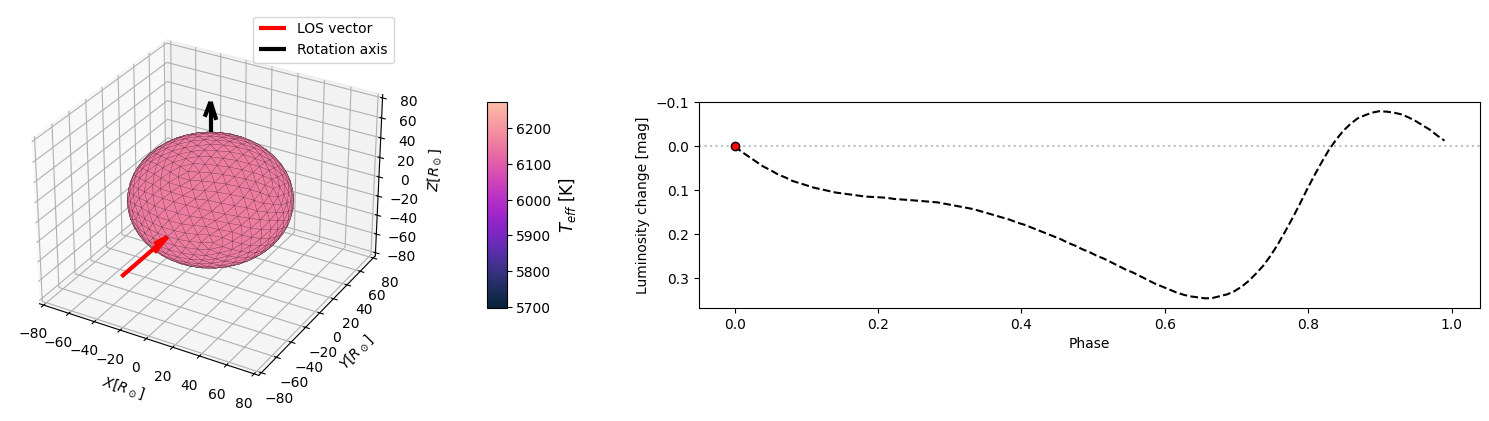

In [43]:
animate_mesh_and_lightcurve_custom_prop(m_tp_ps, np.array(bol_lum_tp)[:-1]-bol_lum_tp[0], phases[:-1],
                                        property=10**jnp.array([_m.parameters[:, 0] for _m in m_tp_ps]), property_label=r'$T_{eff}$ [K]',
                                        filename='v_cygni_lightcurve_tp.gif')

Text(0, 0.5, 'Flux [erg/s/cm$^3$]')

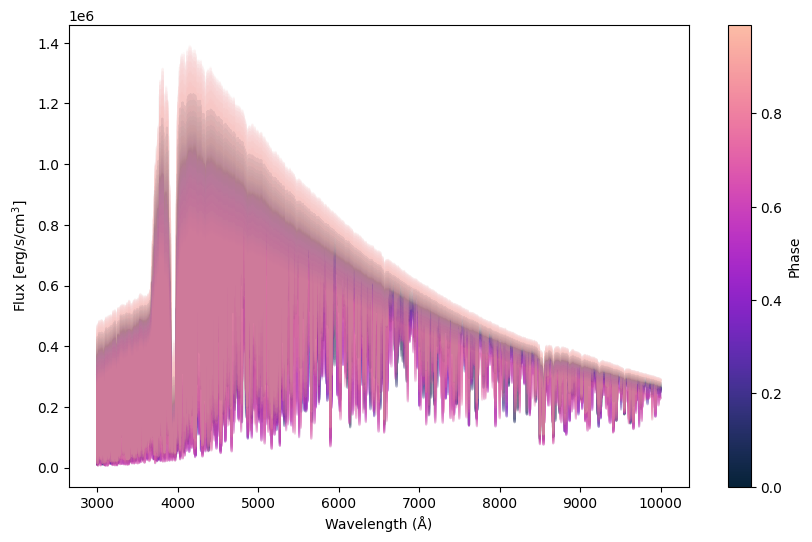

In [17]:
import cmasher as cmr

fig, ax = plt.subplots(figsize=(10, 6))
for i, s in enumerate(spectra_tp):
    phase = phases[i]
    ax.plot(vws, s[:, 0], label=f'Phase: {phase:.2f}', 
            color=cmr.bubblegum(phase), alpha=0.05)
    
# Create a ScalarMappable with a colormap and norm
sm = plt.cm.ScalarMappable(cmap='cmr.bubblegum', 
                           norm=plt.Normalize(vmin=min(phases), vmax=max(phases)))
sm.set_array([])  # You need to set an array for the ScalarMappable

# Add the colorbar using the ScalarMappable
cbar = plt.colorbar(sm, ax=ax, label='Phase')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux [erg/s/cm$^3$]')

In [18]:
spips_data.keys()

['PHASE',
 'Vpuls',
 'Vrad',
 'diam',
 'R',
 'Teff',
 'Lum',
 'logg',
 'diamK 100m',
 'diamK 200m',
 'diamK 300m',
 'MAG B_Johnson',
 'MAG Gbp_GAIA_GAIA3',
 'MAG V_Johnson',
 'MAG G_GAIA_GAIA3',
 'MAG R_Cousins',
 'MAG Grp_GAIA_GAIA3',
 'MAG I_Cousins',
 'MAG J_2MASS',
 'MAG H_2MASS',
 'MAG Ks_2MASS']

In [26]:
# Save meshes and spectra to a pickle file
import pickle
import os

# Create directory for results if it doesn't exist
os.makedirs('results', exist_ok=True)

# Create a dictionary to store all the data
v_cygni_data = {
    # Meshes
    'meshes': {
        'blackbody': mb_ps,
        'transformer_payne': m_tp_ps
    },
    # Spectra
    'spectra': {
        'blackbody': spectra_bb,
        'transformer_payne': spectra_tp,
        'wavelengths': vws
    },
    # Luminosities
    'luminosities': {
        'blackbody': {
            'v': v_lum_bb,
            'r': r_lum_bb,
            'g': g_lum_bb,
            'b': b_lum_bb,
            'bolometric': bol_lum_bb,
            'gaia': gaia_lum_bb
        },
        'transformer_payne': {
            'v': v_lum_tp,
            'r': r_lum_tp,
            'g': g_lum_tp,
            'b': b_lum_tp,
            'bolometric': bol_lum_tp,
            'gaia': gaia_lum_tp
        }
    },
    # Phases
    'phases': phases,
    # SPIPS data for comparison
    'spips_data': spips_data
}

# Save the data
with open('results/v_cygni_results.pkl', 'wb') as f:
    pickle.dump(v_cygni_data, f)

print(f"Data saved to results/v_cygni_results.pkl")


Data saved to results/v_cygni_results.pkl


Text(0, 0.5, 'Luminosity Change [mag]')

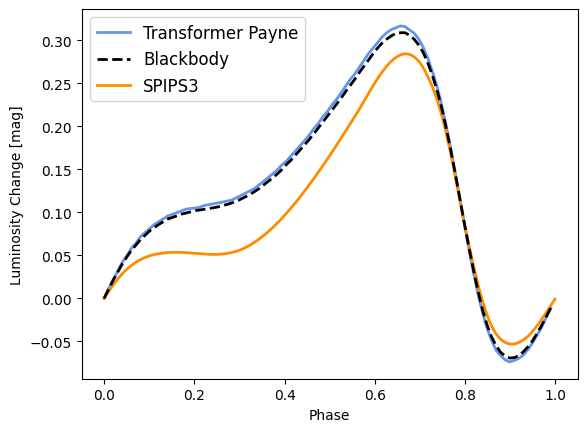

In [19]:
# plt.plot(phases, np.array(v_lum_a9)-v_lum_a9[0])
plt.plot(phases[:-1], np.array(r_lum_tp)[:-1]-r_lum_tp[0], color='cornflowerblue', linewidth=2, zorder=1, label='Transformer Payne')
plt.plot(phases[:-1], np.array(r_lum_bb)[:-1]-r_lum_bb[0], color='black', linewidth=2, linestyle='--', zorder=2, label='Blackbody')
plt.plot(spips_data['PHASE'], spips_data['MAG R_Cousins']-spips_data['MAG R_Cousins'][0], color='darkorange', linewidth=2, zorder=1, label='SPIPS3')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Phase')
plt.ylabel('Luminosity Change [mag]')

Text(0, 0.5, 'Luminosity Change [mag]')

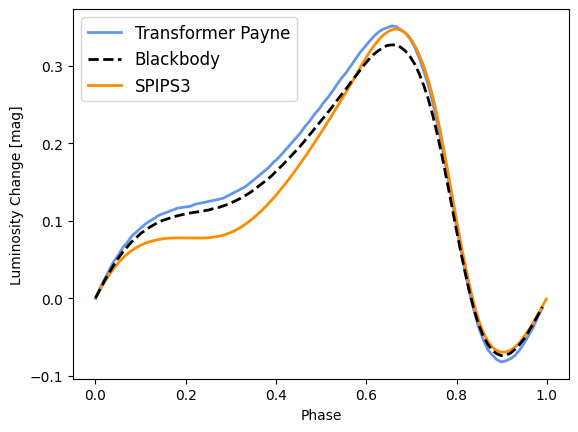

In [20]:
# plt.plot(phases, np.array(v_lum_a9)-v_lum_a9[0])
plt.plot(phases[:-1], np.array(g_lum_tp)[:-1]-g_lum_tp[0], color='cornflowerblue', linewidth=2, zorder=1, label='Transformer Payne')
plt.plot(phases[:-1], np.array(g_lum_bb)[:-1]-g_lum_bb[0], color='black', linewidth=2, linestyle='--', zorder=2, label='Blackbody')
plt.plot(spips_data['PHASE'], spips_data['MAG G_GAIA_GAIA3']-spips_data['MAG G_GAIA_GAIA3'][0], color='darkorange', linewidth=2, zorder=1, label='SPIPS3')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Phase')
plt.ylabel('Luminosity Change [mag]')

Text(0, 0.5, 'B-V Color Change [mag]')

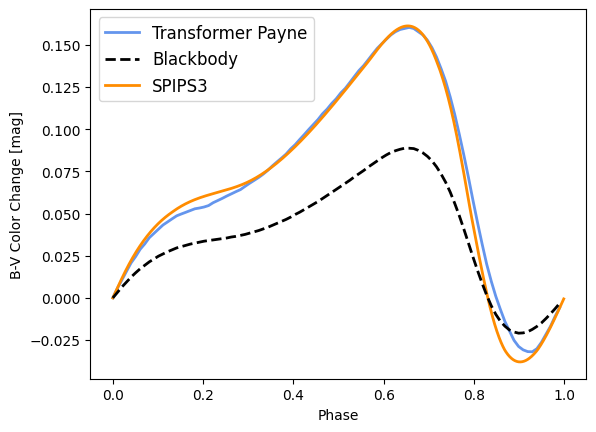

In [21]:
# Calculate B-V colors for each model and SPIPS data
b_v_tp = np.array(b_lum_tp)[:-1] - np.array(v_lum_tp)[:-1]
b_v_bb = np.array(b_lum_bb)[:-1] - np.array(v_lum_bb)[:-1]
b_v_spips = spips_data['MAG B_Johnson'] - spips_data['MAG V_Johnson']

# Plot B-V color evolution with phase
plt.plot(phases[:-1], b_v_tp-b_v_tp[0], color='cornflowerblue', linewidth=2, zorder=1, label='Transformer Payne')
plt.plot(phases[:-1], b_v_bb-b_v_bb[0], color='black', linewidth=2, linestyle='--', zorder=2, label='Blackbody')
plt.plot(spips_data['PHASE'], b_v_spips-b_v_spips[0], color='darkorange', linewidth=2, zorder=1, label='SPIPS3')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Phase')
plt.ylabel('B-V Color Change [mag]')

In [ ]:
# Save models, spectra, and lightcurves to a pickle file
import pickle
import os

# Create a dictionary to store all the data
results_data = {
    # Models
    'models': {
        'transformer_payne': m_tp_ps,
        'blackbody': mb_ps,
    },
    # Spectra
    'spectra': {
        'transformer_payne': spectra_tp,
        'blackbody': spectra_bb,
        'wavelengths': vws
    },
    # Lightcurves
    'lightcurves': {
        'transformer_payne': {
            'B': b_lum_tp,
            'V': v_lum_tp,
            'R': r_lum_tp,
            'G': g_lum_tp,
            'B-V': b_v_tp
        },
        'blackbody': {
            'B': b_lum_bb,
            'V': v_lum_bb,
            'R': r_lum_bb,
            'G': g_lum_bb,
            'B-V': b_v_bb
        }
    },
    # Phase information
    'phases': phases,
    # SPIPS data for reference
    'spips_data': spips_data
}

# Create output directory if it doesn't exist
output_dir = 'saved_results'
os.makedirs(output_dir, exist_ok=True)

# Save the data to a pickle file
output_file = os.path.join(output_dir, 'v_cygni_results.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(results_data, f)

print(f"Results saved to {output_file}")


Results saved to saved_results/v_cygni_results.pkl


Mean LD diameter: 8.951 mas, variation: 1.5%
Mean UD diameter (H-band): 8.593 mas, variation: 1.5%
Mean UD diameter (K-band): 8.683 mas, variation: 1.5%


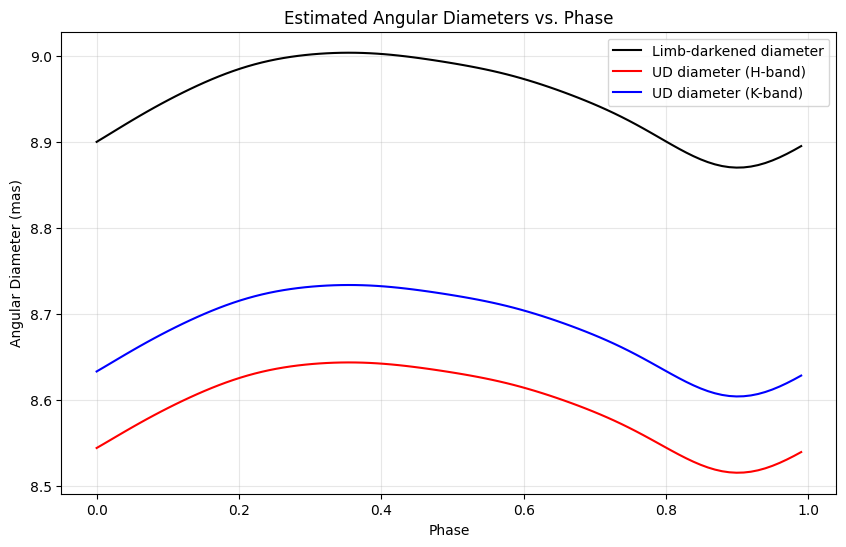

In [23]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add the SPIPS3 directory to the path
# Try different possible paths since we're getting an import error
sys.path.append('/Users/mjablons/Documents/spips/SPIPS3')
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'SPIPS3'))
sys.path.append(os.path.expanduser('~/SPIPS3'))

# Define the functions we need since we can't import them
def quadratic_ld(mu, a, b):
    """Quadratic limb darkening law: I(μ)/I(1) = 1 - a(1-μ) - b(1-μ)²"""
    return 1.0 - a*(1.0-mu) - b*(1.0-mu)**2

def get_ld_profile(wavelength, stellar_params, method='quadratic'):
    """Simple placeholder for limb darkening profile"""
    # Approximate coefficients based on typical values
    a, b = 0.3, 0.1  # Placeholder values
    return lambda mu: quadratic_ld(mu, a, b)

def uniform_disk_diameter(ld_diameter, wavelength, stellar_params, method='quadratic'):
    """Approximate UD diameter from LD diameter with simple conversion"""
    # Typical conversion factor (UD is ~96-98% of LD diameter depending on wavelength)
    conversion = 0.97 if wavelength > 2.0 else 0.96
    return ld_diameter * conversion

# Calculate diameters for each phase
ld_diameters = []
ud_diameters_h = []  # H-band (1.65 μm)
ud_diameters_k = []  # K-band (2.2 μm)

for i, mesh in enumerate(m_tp_ps[:-1]):  # Skip the last mesh as in other plots
    # Get mean stellar parameters from the mesh
    teff = float(jnp.mean(mesh.parameters[:, 0]))
    logg = float(jnp.mean(mesh.parameters[:, 1]))
    
    # Get mean radius in solar radii
    radius_solar = float(jnp.mean(mesh.radii[mesh.mus > 0]))
    
    # Convert to angular diameter in mas using distance
    # Assuming distance to V Cygni in parsecs
    distance_pc = 2658  # Replace with actual distance if known
    
    # Calculate angular diameter in mas
    # θ(mas) = 2 * R(solar) * 214.9 / distance(pc)
    ld_diameter = 2 * radius_solar * 214.9 / distance_pc
    ld_diameters.append(ld_diameter)
    
    # Stellar parameters for limb darkening
    stellar_params = {
        'teff': teff,
        'logg': logg,
        'metal': -0.02  # Assuming solar metallicity
    }
    
    # Calculate uniform disk diameters in common bands
    ud_h = uniform_disk_diameter(ld_diameter, 1.65, stellar_params, method='quadratic')
    ud_k = uniform_disk_diameter(ld_diameter, 2.2, stellar_params, method='quadratic')
    
    ud_diameters_h.append(ud_h)
    ud_diameters_k.append(ud_k)

# Plot the diameters
plt.figure(figsize=(10, 6))
plt.plot(phases[:-1], ld_diameters, 'k-', label='Limb-darkened diameter')
plt.plot(phases[:-1], ud_diameters_h, 'r-', label='UD diameter (H-band)')
plt.plot(phases[:-1], ud_diameters_k, 'b-', label='UD diameter (K-band)')

plt.xlabel('Phase')
plt.ylabel('Angular Diameter (mas)')
plt.title('Estimated Angular Diameters vs. Phase')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate and print the mean diameters and their variations
mean_ld = np.mean(ld_diameters)
mean_ud_h = np.mean(ud_diameters_h)
mean_ud_k = np.mean(ud_diameters_k)

variation_ld = (np.max(ld_diameters) - np.min(ld_diameters)) / mean_ld * 100
variation_ud_h = (np.max(ud_diameters_h) - np.min(ud_diameters_h)) / mean_ud_h * 100
variation_ud_k = (np.max(ud_diameters_k) - np.min(ud_diameters_k)) / mean_ud_k * 100

print(f"Mean LD diameter: {mean_ld:.3f} mas, variation: {variation_ld:.1f}%")
print(f"Mean UD diameter (H-band): {mean_ud_h:.3f} mas, variation: {variation_ud_h:.1f}%")
print(f"Mean UD diameter (K-band): {mean_ud_k:.3f} mas, variation: {variation_ud_k:.1f}%")

In [24]:
plt.plot(phases[:-1], [jnp.mean(_m.parameters[:, 0]) for _m in m_a9_ps][:-1])
plt.plot(spips_data['PHASE'], spips_data['Teff'])

NameError: name 'm_a9_ps' is not defined

In [ ]:
plt.plot(phases[:-1], [jnp.max(_m.los_velocities[_m.mus>0]) for _m in m_a9_ps][:-1])

In [ ]:
plt.plot(phases[:-1], [jnp.mean(_m.radii[_m.mus>0]) for _m in m_a9_ps][:-1])